# Pytorch Neural Network Implementation with Iris Dataset

### Download Iris Dataset

In [2]:
from lib.helpers import download_data, XOR
DATA_URL = 'https://archive.ics.uci.edu/ml/machine-learning-databases/iris/iris.data'
# Import Iris dataset
if not download_data(DATA_URL):
    print('problem downloading file; try again or check logs')

/usr/lib/python3/dist-packages/requests/__init__.py:89: RequestsDependencyWarning: urllib3 (1.26.9) or chardet (3.0.4) doesn't match a supported version!
  warnings.warn("urllib3 ({}) or chardet ({}) doesn't match a supported "


### Creating Essential Classes
Pytorch makes it easier to manage your dataset by extending the `Dataset` class, and to be used with the `DataLoader` class

In [3]:
# create dataset class
import pandas as pd
import torch
from torch.utils.data import Dataset, DataLoader
from torch.nn.functional import one_hot
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

class IrisDataset(Dataset):
    def __init__(self,**kwargs):
        args = kwargs.keys() # dict of argument keywords
        # XOR       
        if XOR('data_path' in args, 'X' in args):
            if 'data_path' in args:
                self.transform=None if 'transform' not in args else kwargs['transform']
                header='infer' if 'header' not in args else kwargs['header']
                skiprows=0 if 'skiprows' not in args else kwargs['skiprows']
                self.data_path = kwargs['data_path']
                self.data = pd.read_csv(self.data_path, header=header, skiprows=skiprows)
                self.features = torch.tensor(self.data[self.data.columns[0:-1]].values).float()
                self.labels_string = self.data[self.data.columns[-1]]
                # self.label_levels = self.labels_string.unique()
                # encode labels
                le = LabelEncoder()
                self.labels = torch.tensor(le.fit_transform(self.labels_string.values))
                self.label_mapping = dict(zip(le.transform(le.classes_),le.classes_))

            else:
                self.features = kwargs['X']
                self.labels = kwargs['Y']
        else:
            raise "Either data_path or X but not both can be accepted as parameters"
    def __len__(self):
        return len(self.features)
    def __getitem__(self, idx): # __getitem__() gets row with index number, returns features(as tensor) and label
        # feature =self.transform(self.features[idx]) if self.transform else  self.features[idx]
        return self.features[idx], self.labels[idx]
    # splits dataset into test and train, returns IrisDataset objects for train and test, respectively
    def train_test_split(self, test_size=0.25, random_state=42, shuffle=False):
        X_train, X_test, Y_train, Y_test  = train_test_split(self.features, self.labels, test_size=test_size, random_state=random_state, shuffle=shuffle)
        return IrisDataset(X=X_train,Y=Y_train), IrisDataset(X=X_test,Y=Y_test)

In [4]:
data_set = IrisDataset(data_path='data/iris.data', header=None)

In [5]:
# show labels/targets as names
data_set.label_mapping

{0: 'Iris-setosa', 1: 'Iris-versicolor', 2: 'Iris-virginica'}

In [6]:
# get dataset size
len(data_set)

150

### Visualisation of the Data
We want to visualise the type of data we're working with so we can figure out what the best approach is. We could use SVM for this probelm, but in this example we're going to implement a simple MLP(Multi-Layer Perceptron) in Pytorch, since this is the purpose of this notebook.

In [7]:
# subset the data by species
setosa_bool = data_set.data[4]== 'Iris-setosa'
virginica_bool = data_set.data[4] == 'Iris-virginica'
versicolor_bool = data_set.data[4] == 'Iris-versicolor'

setosa = data_set.data.loc[setosa_bool,:]
virginica = data_set.data.loc[virginica_bool,:]
versicolor = data_set.data.loc[versicolor_bool,:]

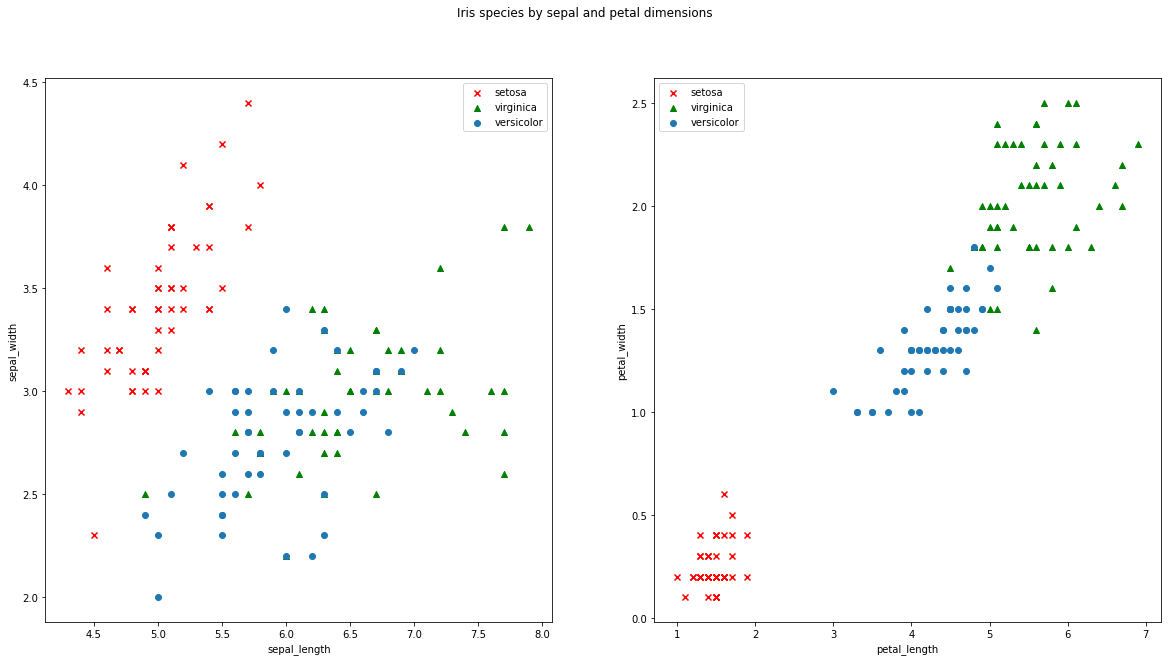

In [8]:
# visualise the dataset
import matplotlib.pyplot as plt

fig,ax = plt.subplots(1,2, figsize=(20,10))
ax[0].scatter(setosa[[0]],setosa[[1]], color='red', marker='x', label='setosa')
ax[0].scatter(virginica[[0]],virginica[[1]], color='green', marker='^', label='virginica')
ax[0].scatter(versicolor[[0]],versicolor[[1]], label='versicolor')
ax[1].scatter(setosa[[2]],setosa[[3]], color='red', marker='x', label='setosa')
ax[1].scatter(virginica[[2]],virginica[[3]], color='green', marker='^', label='virginica')
ax[1].scatter(versicolor[[2]],versicolor[[3]], label='versicolor')
ax[0].set_xlabel('sepal_length')
ax[0].set_ylabel('sepal_width')
ax[1].set_xlabel('petal_length')
ax[1].set_ylabel('petal_width')
ax[0].legend()
ax[1].legend()
fig.suptitle('Iris species by sepal and petal dimensions')
plt.show()

### Defining the Neural Network class
Next, we need to define the neural network by extendig the `torch.nn.Module` class. 1st layer is Linear with 4 inputs(number of features) and a final Linear layer with 3 outputs(number of classes)

In [9]:

# define NeuralNet class
class NN(torch.nn.Module):
    def __init__(self):
        super(NN, self).__init__()
        self.flatten = torch.nn.Flatten()
        self.linear_relu_stack = torch.nn.Sequential( ## 1 Linear, 2-relu stack
            torch.nn.Linear(4,50),
            torch.nn.ReLU(),
            torch.nn.Linear(50,3), # will have 3 outputs(3 classes in training set(setosa,virginica,versicolor))
        )
    def forward(self, x):
        #x = self.flatten(x)
        logits = self.linear_relu_stack(x)
        return logits
        # return torch.nn.functional.softmax(logits, dim=1) 

In [10]:
device = "cuda" if torch.cuda.is_available() else "cpu"
print(f"Using {device} device")

Using cuda device


In [11]:
# send to device(if available, to GPU)
model = NN().to(device)
print(model)

NN(
  (flatten): Flatten(start_dim=1, end_dim=-1)
  (linear_relu_stack): Sequential(
    (0): Linear(in_features=4, out_features=50, bias=True)
    (1): ReLU()
    (2): Linear(in_features=50, out_features=3, bias=True)
  )
)


In [12]:
# Define loss function and optimisation
loss_fn = torch.nn.CrossEntropyLoss()
# optimizer = torch.optim.SGD(model.parameters(), lr=1e-3)
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [13]:
# split into train and test
train_data,test_data = data_set.train_test_split(test_size=20, shuffle=True)
train_dataloader = DataLoader(train_data, batch_size=5)
test_dataloader = DataLoader(test_data, batch_size=5, shuffle=True)

In [14]:
# Define train and test functions
def train(dataloader, model, loss_fn, optimizer):
    size = len(dataloader.dataset)
    num_out = 10/dataloader.batch_size # desired number of outputs
    model.train() # sets model into 'training mode'
    for batch, (X, y) in enumerate(dataloader):
        X, y = X.to(device), y.to(device)

        # Compute prediction error
        pred = model(X)
        loss = loss_fn(pred, y)

        # Backpropagation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        if batch % num_out == 0:
            loss = loss.item()
            current = batch * len(X)
            print(f"loss: {loss:>7f}  [{current:>5d}/{size:>5d}]")
            
def test(dataloader, model, loss_fn):
    size = len(dataloader.dataset)
    num_batches = len(dataloader)
    model.eval() # sets to 'eval mode'
    test_loss, correct = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            X, y = X.to(device), y.to(device)
            pred = model(X)
            # pred returns the tensor of the predictions/output; torch.argmax() returns the index of highest value in the input tensor
            # index number = class/label name
            # the higher the value, the higher the probability
            # eg, if pred.argmax(dim=1) == 0
            # input has a high probability of class 0
            # check label mapping which name corresponds with class 0
            # eg, 'Iris-setosa' == class 0
            test_loss += loss_fn(pred, y).item()
            correct += (pred.argmax(1) == y).type(torch.float).sum().item() # dim=1 find max in tensor row-wise
    test_loss /= num_batches
    correct /= size
    print(f"Test Error: \n Accuracy: {(100*correct):>0.1f}%, Avg loss: {test_loss:>8f} \n")

In [15]:
epochs = 10
for t in range(epochs):
    print(f"Epoch {t+1}\n-------------------------------")
    train(train_dataloader, model, loss_fn, optimizer)
    test(test_dataloader, model, loss_fn)

Epoch 1
-------------------------------
loss: 0.814631  [    0/  130]
loss: 0.989639  [   10/  130]
loss: 1.132900  [   20/  130]
loss: 1.052226  [   30/  130]
loss: 0.954001  [   40/  130]
loss: 0.899063  [   50/  130]
loss: 1.071734  [   60/  130]
loss: 1.021977  [   70/  130]
loss: 0.922286  [   80/  130]
loss: 1.027514  [   90/  130]
loss: 1.143759  [  100/  130]
loss: 0.798675  [  110/  130]
loss: 1.007324  [  120/  130]
Test Error: 
 Accuracy: 55.0%, Avg loss: 0.981483 

Epoch 2
-------------------------------
loss: 0.811996  [    0/  130]
loss: 0.852054  [   10/  130]
loss: 0.939403  [   20/  130]
loss: 0.896240  [   30/  130]
loss: 0.902146  [   40/  130]
loss: 0.830365  [   50/  130]
loss: 0.933558  [   60/  130]
loss: 0.897606  [   70/  130]
loss: 0.863477  [   80/  130]
loss: 0.903370  [   90/  130]
loss: 1.000466  [  100/  130]
loss: 0.778915  [  110/  130]
loss: 0.918293  [  120/  130]
Test Error: 
 Accuracy: 55.0%, Avg loss: 0.887215 

Epoch 3
----------------------------

In [16]:
# predict function, accepts torch Dataset row object(tuple)
def predict(p: tuple, labels: dict, model):
    inputs = p[0].to('cuda')
    target = p[1].item()
    pred = model(inputs).argmax().item()
    print(f'actual: {target}, name: {labels[target]}')
    print(f'predicted: {pred}, name: {labels[pred]}')


In [17]:
# running test predictions
predict(data_set[5], data_set.label_mapping, model)
predict(data_set[45], data_set.label_mapping, model)
predict(data_set[69], data_set.label_mapping, model)
predict(data_set[100], data_set.label_mapping, model)

actual: 0, name: Iris-setosa
predicted: 0, name: Iris-setosa
actual: 0, name: Iris-setosa
predicted: 0, name: Iris-setosa
actual: 1, name: Iris-versicolor
predicted: 1, name: Iris-versicolor
actual: 2, name: Iris-virginica
predicted: 2, name: Iris-virginica
